# WanderBuddy with ArangoDB, Langchain and cuGraph

# Step 0: Package Installation & Setup


In [1]:
# 1. Check if you have an NVIDA GPU
#Note: If this returns "Command not found", then the GPU based algorithms via cuGraph are unavailable
!nvidia-smi
!nvcc --version

Sat Mar  8 19:30:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
%%capture
# 2. Install nx-arangodb via pip
# Github: https://github.com/arangodb/nx-arangodb
!pip install nx-arangodb

# 3. Install nx-cugraph via pip
# Note: Only enable this installation if the step above is working!
!pip install nx-cugraph-cu12 --extra-index-url https://pypi.nvidia.com # Requires CUDA-capable GPU

# 4. Install LangChain & LangGraph
!pip install --upgrade langchain langchain-community langchain-openai langgraph

# 5. Install other common dependencies
!pip install networkx matplotlib pandas numpy requests

In [4]:
%%capture

# 6. Install the dependencies

!pip install python-arango # The ArangoDB Python Driver
!pip install adb-cloud-connector # The ArangoDB Cloud Instance provisioner
!pip install arango-datasets # Datasets package
!pip install openai==1.6.1
!pip install langchain==0.1.0

In [6]:
%%capture
# 7. Upgrading OpenAI and Langchain to the right config.
!pip install --upgrade langchain-openai
!pip install --upgrade langchain langchain-community langchain-openai langgraph

In [7]:
%%capture
# 8. Installing Gradio for Chatbot.
!pip install openai gradio

In [8]:
# 9. Import Required Modules**

import networkx as nx
import nx_arangodb as nxadb
from arango import ArangoClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint

from dotenv import load_dotenv
import os
import re
import requests
import http.client
import json
import time
import hashlib
import importlib

import openai
import langchain_community.chat_models

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool

from langchain_community.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain_community.chat_models import ChatOpenAI

from langchain.memory import ConversationBufferMemory
from langchain.agents import initialize_agent, AgentType

import gradio as gr

[19:33:28 +0000] [INFO]: NetworkX-cuGraph is available.
INFO:nx_arangodb:NetworkX-cuGraph is available.


In [9]:
# 10. Import the .env files containing the relevant passwords.

from google.colab import files
uploaded = files.upload()

Saving config.env to config.env


In [10]:
# 11. Load environment variables from the file
load_dotenv("/content/config.env")  # Update path if needed

# 12. Get credentials
openai_api_key = os.getenv("OPENAI_API_KEY")
arango_url = os.getenv("ARANGO_URL")
arango_username = os.getenv("ARANGO_USERNAME")
arango_password = os.getenv("ARANGO_PASSWORD")
arango_dbname = os.getenv("ARANGO_DBNAME")
rapidapi_key = os.getenv("RAPIDAPI_KEY")
rapidapi_host = os.getenv("RAPIDAPI_HOST")


# Step 1: Connecting to ArangoDB

In [13]:
# 13. Connect to the ArangoDB database.

def setup_arangodb():
    global db
    try:
        print(f"🔄 Connecting to ArangoDB Cloud at {arango_url}...")

        # ✅ Initialize ArangoDB Client
        client = ArangoClient(hosts=arango_url)

        # ✅ Connect to the specified database
        db = client.db(
            arango_dbname,
            arango_username,
            arango_password,
            verify=True  # Secure connection
        )

        print(f"✅ Successfully connected to ArangoDB Cloud: {db.name}")

        # ✅ Ensure required collections exist
        for collection in ["hotels", "attractions", "hotel_links", "attraction_links", "cities", "destinations", "flight_destinations", "flights"]:
            if not db.has_collection(collection):
                db.create_collection(collection)

        # ✅ Ensure graph exists
        if not db.has_graph('TravelGraph'):
            #db.create_graph('TravelGraph')
            # Define the graph with edge collections
            graph = db.create_graph(
                "TravelGraph",
                edge_definitions=[
                    {
                        "edge_collection": "flights",
                        "from_vertex_collections": ["cities"],
                        "to_vertex_collections": ["cities"]
                    },
                    {
                        "edge_collection": "hotel_links",
                        "from_vertex_collections": ["cities"],
                        "to_vertex_collections": ["hotels"]
                    },
                    {
                        "edge_collection": "attraction_links",
                        "from_vertex_collections": ["cities"],
                        "to_vertex_collections": ["attractions"]
                    }
                ]
            )

        return db

    except Exception as e:
        print(f"❌ ArangoDB Cloud Connection Error: {e}")
        db = None
        return None

# ✅ Run Setup
db = setup_arangodb()
print(db.graphs())
print(db.collections())


🔄 Connecting to ArangoDB Cloud at https://c4c335acccb7.arangodb.cloud:8529...
✅ Successfully connected to ArangoDB Cloud: Langchain
[{'id': '_graphs/TravelGraph', 'name': 'TravelGraph', 'revision': '_jRyRw9W---', 'orphan_collections': [], 'edge_definitions': [], 'shard_count': None, 'replication_factor': None}]
[{'id': '1053', 'name': '_queues', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '724747', 'name': 'attractions', 'system': False, 'type': 'document', 'status': 'loaded'}, {'id': '1052', 'name': '_aqlfunctions', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '724772', 'name': 'flight_destinations', 'system': False, 'type': 'document', 'status': 'loaded'}, {'id': '1054', 'name': '_jobs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '724742', 'name': 'hotels', 'system': False, 'type': 'document', 'status': 'loaded'}, {'id': '724767', 'name': 'destinations', 'system': False, 'type': 'document', 'status': 'loaded'}, {'id': '72476

In [12]:
# Backup Function if needed to delete collections in ArangoDB - (OPTIONAL)
def delete_collections(db, collections):
    for collection in collections:
        if db.has_collection(collection):
            db.delete_collection(collection)  # Correct method to delete the entire collection
            print(f"🗑️ Deleted collection: {collection}")
        else:
            print(f"⚠️ Collection '{collection}' does not exist.")

# List of collections to delete
collections_to_delete = ["hotels", "attractions", "hotel_links", "attraction_links", "cities", "destinations", "flight_destinations", "flights"]

# Call the function to delete collections
delete_collections(db, collections_to_delete)


🗑️ Deleted collection: hotels
🗑️ Deleted collection: attractions
🗑️ Deleted collection: hotel_links
🗑️ Deleted collection: attraction_links
🗑️ Deleted collection: cities
🗑️ Deleted collection: destinations
🗑️ Deleted collection: flight_destinations
🗑️ Deleted collection: flights


# Step 3: Functions to obtain features for NetworkX

In [14]:
# 15. Function to get the Destination ID of the city using RAPID API's key for Booking.com
#     Once the destination ID is obtained, this function then stores the destination in the ArangoDB in the collections "destinations".

def get_destination_id(destination):
    conn = http.client.HTTPSConnection(rapidapi_host)
    headers = {
        'x-rapidapi-key': rapidapi_key,
        'x-rapidapi-host': rapidapi_host
    }

    request_url = f"/api/v1/hotels/searchDestination?query={destination}"
    conn.request("GET", request_url, headers=headers)
    res = conn.getresponse()
    data = res.read()

    try:
        destination_data = json.loads(data.decode("utf-8"))
        if 'data' in destination_data and isinstance(destination_data['data'], list) and len(destination_data['data']) > 0:
            city_destinations = [d for d in destination_data['data'] if d.get('search_type') == 'city']

            if not city_destinations:
                print(f"Error: No city-level destinations found for {destination}.")
                return None, None

            best_match = city_destinations[0]
            dest_id = best_match.get('dest_id', 'N/A')
            search_type = best_match.get('search_type', 'N/A')

            print(f"✅ Selected Destination: {best_match.get('name')}, ID: {dest_id}, Type: {search_type}")
            # ✅ **Store destination in the database**
            if not db.collection("destinations").has(dest_id):
                db.collection("destinations").insert({
                    "_key": str(dest_id),
                    "name": best_match.get("name", destination),
                    "dest_id": dest_id,
                    "search_type": search_type
                })
                print(f"🗺️ Destination '{best_match.get('name')}' added to database.")

            return dest_id, search_type
        else:
            print(f"❌ Error: No valid destinations found in API response for {destination}.")
            return None, None
    except json.JSONDecodeError as e:
        print(f"❌ Error decoding JSON response for {destination}:", e)
        return None, None

In [15]:
# 16. Function to get the Hotels in the destination city using RAPID API's key for Booking.com
#     Once the Hotels is obtained, this function then stores the destination in the ArangoDB in the collections "hotels".

# Define a global hotel ID counter - A backup just in case, the hotel ID is not being generated.
global_hotel_id = 1

def get_hotels_in_destination(destination, arrival_date, departure_date, adults=1, children_age="0,17", room_qty=1, page_number=1, currency="USD"):
    global global_hotel_id  # Use the global variable for unique hotel IDs

    dest_id, search_type = get_destination_id(destination)
    if not dest_id or not search_type:
        print(f"❌ Error: Could not retrieve destination ID for {destination}.")
        return

    conn = http.client.HTTPSConnection(rapidapi_host)
    headers = {
        'x-rapidapi-key': rapidapi_key,
        'x-rapidapi-host': rapidapi_host
    }

    request_url = f"/api/v1/hotels/searchHotels?dest_id={dest_id}&search_type={search_type}&adults={adults}&children_age={children_age}&room_qty={room_qty}&page_number={page_number}&units=metric&temperature_unit=c&languagecode=en-us&currency_code={currency}&arrival_date={arrival_date}&departure_date={departure_date}"

    conn.request("GET", request_url, headers=headers)
    res = conn.getresponse()
    data = res.read()

    try:
        hotels_data = json.loads(data.decode("utf-8"))

        # Ensure correct structure
        if 'data' in hotels_data and 'hotels' in hotels_data['data']:
            hotels_list = hotels_data['data']['hotels']

            print(f"\n🏨 **Hotels Found in {destination}:**")
            print("="*60)

            for hotel in hotels_list:
                property_info = hotel.get('property', {})

                retry_attempts = 2  # Maximum retries if hotel_id is None
                wait_time = 0.1  # Seconds to wait between retries

                hotel_id = property_info.get('hotel_id', None)

                # Retry fetching hotel_id if it's None
                while hotel_id is None and retry_attempts > 0:
                    print(f"🔄 Retrying to fetch hotel_id for hotel in {destination}... ({4 - retry_attempts}/3)")
                    time.sleep(wait_time)  # Wait before retrying
                    hotel_id = property_info.get('hotel_id', None)  # Re-fetch hotel_id
                    retry_attempts -= 1

                # If still no valid hotel_id, use global_hotel_id as a fallback
                if hotel_id is None:
                    print(f"❌ API did not return a hotel_id for this hotel in {destination}. Assigning fallback ID: {global_hotel_id}")
                    hotel_id = f"fallback_{global_hotel_id}"  # Assign a unique fallback ID
                    global_hotel_id += 1  # Increment global counter for next fallback ID

                print(f"✅ Using hotel_id: {hotel_id} for {property_info.get('name', 'Unknown Hotel')}")

                hotel_name = property_info.get('name', 'N/A')
                rating = property_info.get('accuratePropertyClass', 'N/A')
                review_score = property_info.get('reviewScore', 'N/A')
                review_count = property_info.get('reviewCount', 'N/A')

                # Price breakdown
                price_info = property_info.get('priceBreakdown', {})
                price = price_info.get('grossPrice', {}).get('value', 'N/A')
                currency = price_info.get('grossPrice', {}).get('currency', currency)

                # Hotel images
                images = property_info.get('photoUrls', [])
                first_image = images[0] if images else "No Image Available"

                # Print hotel details
                print(f"🏨 **{hotel_name}**")
                print(f"🆔 ID: {hotel_id}")
                print(f"⭐ Rating: {rating} Stars | 🏆 Review Score: {review_score} ({review_count} reviews)")
                print(f"💰 Price per Night: {price} {currency}")
                print(f"📸 Image: {first_image}")
                print("="*60)

                # ✅ **Store the hotel in the database**
                if not db.collection("hotels").has(hotel_id):
                  sanitized_key = hashlib.md5(hotel_name.encode()).hexdigest()  # Generate a valid key
                  db.collection("hotels").insert({
                      "_key": sanitized_key,
                      "name": hotel_name,
                      "destination": destination,
                      "rating": rating,
                      "review_score": review_score,
                      "review_count": review_count,
                      "price": price,
                      "currency": currency,
                      "image": first_image
                  })
                  print(f"🏨 Hotel '{hotel_name}' added to database with key: {sanitized_key}")

        else:
            print(f"❌ Error: 'hotels' key not found for {destination}. Check API response structure.")

    except json.JSONDecodeError as e:
        print(f"❌ Error decoding JSON response for {destination}:", e)


In [16]:
# 17. Function to get the Attractions in the destination city using RAPID API's key for Booking.com
#     Once the Attractions is obtained, this function then stores the destination in the ArangoDB in the collections "attractions".

def get_attraction_location(destination):
    conn = http.client.HTTPSConnection(rapidapi_host)
    headers = {
        'x-rapidapi-key': rapidapi_key,
        'x-rapidapi-host': rapidapi_host
    }
    request_url = f"/api/v1/attraction/searchLocation?query={destination}&languagecode=en-us"
    conn.request("GET", request_url, headers=headers)
    res = conn.getresponse()
    data = res.read()

    try:
        attractions_data = json.loads(data.decode("utf-8"))
        if 'data' in attractions_data and 'products' in attractions_data['data']:
            print(f"\n🎡 **Attractions in {destination}:**")
            print("="*60)

            for attraction in attractions_data['data']['products']:
                title = attraction.get('title', 'N/A')
                product_id = attraction.get('productId', 'N/A')
                category = attraction.get('taxonomySlug', 'N/A').replace('-', ' ').title()

                print(f"🔹 **{title}**")
                print(f"   🔗 Product ID: {product_id}")
                print(f"   🌍 Category: {category}")
                print("-"*60)

                # ✅ **Store the attraction in the database**
                if not db.collection("attractions").has(product_id):
                  sanitized_key = hashlib.md5(f"{title}_{product_id}".encode()).hexdigest()  # Generate a valid key
                  db.collection("attractions").insert({
                      "_key": sanitized_key,
                      "name": title,
                      "destination": destination,
                      "category": category
                  })
                  print(f"🎡 Attraction '{title}' added to database with key: {sanitized_key}")

        else:
            print(f"❌ No attractions found for {destination}.")
    except json.JSONDecodeError as e:
        print(f"❌ Error decoding JSON response for {destination}:", e)

In [17]:
# 18. Function to get the Flight Destination ID in the destination city using RAPID API's key for Booking.com
#     Once the Flight Destination ID is obtained, this function then stores the destination in the ArangoDB in the collections "flight_destinations".

def get_flight_destination_id(city):
    conn = http.client.HTTPSConnection(rapidapi_host)
    headers = {
        'x-rapidapi-key': rapidapi_key,
        'x-rapidapi-host': rapidapi_host
    }
    request_url = f"/api/v1/flights/searchDestination?query={city}"
    conn.request("GET", request_url, headers=headers)
    res = conn.getresponse()
    data = res.read()

    try:
        flight_data = json.loads(data.decode("utf-8"))
        if 'data' in flight_data and isinstance(flight_data['data'], list) and len(flight_data['data']) > 0:
            best_match = flight_data['data'][0]
            flight_id = best_match.get('id', 'N/A')

            print(f"✈️ Flight Destination ID for {city}: {flight_id}")

            # ✅ **Store flight destination in the database**
            if not db.collection("flight_destinations").has(flight_id):
                db.collection("flight_destinations").insert({
                    "_key": str(flight_id),
                    "city": city,
                    "flight_id": flight_id
                })
                print(f"🛫 Flight Destination '{city}' added to database.")

            return flight_id
        else:
            print(f"❌ Error: No flight destination found for {city}.")
            return None
    except json.JSONDecodeError as e:
        print(f"❌ Error decoding JSON response for {city}:", e)
        return None

In [18]:
# 19. Function to get the Flight details to the destination city using RAPID API's key for Booking.com
#     Once the flight details is obtained, this function it returns it back to the search flights function.

def get_flight_details(token, currency="USD"):
    """Fetch detailed flight information using a booking token"""
    conn = http.client.HTTPSConnection(rapidapi_host)
    headers = {
        'x-rapidapi-key': rapidapi_key,
        'x-rapidapi-host': rapidapi_host
    }
    request_url = f"/api/v1/flights/getFlightDetails?token={token}&currency_code={currency}"
    conn.request("GET", request_url, headers=headers)
    res = conn.getresponse()
    data = res.read()

    try:
        flight_details = json.loads(data.decode("utf-8"))
        return flight_details
    except json.JSONDecodeError as e:
        print(f"❌ Error decoding JSON response for flight details:", e)
        return None

In [19]:
# 20. Function to get the provide the flight details to the destination city using RAPID API's key for Booking.com
#     Once the complete info is obtained, this function then stores the destination in the ArangoDB in the collections "flights".

from datetime import datetime


def search_flights(from_city, to_city, departure_date, adults=1, children="0,17", sort="BEST", cabin_class="ECONOMY", currency="USD", page_no=1):
    """Search for flights and retrieve detailed flight info using a token."""
    from_id = get_flight_destination_id(from_city)
    to_id = get_flight_destination_id(to_city)
    if not from_id or not to_id:
        print("❌ Error: Could not retrieve flight destination IDs.")
        return

    conn = http.client.HTTPSConnection(rapidapi_host)
    headers = {
        'x-rapidapi-key': rapidapi_key,
        'x-rapidapi-host': rapidapi_host
    }

    request_url = f"/api/v1/flights/searchFlights?fromId={from_id}&toId={to_id}&pageNo={page_no}&adults={adults}&children={children}&sort={sort}&cabinClass={cabin_class}&currency_code={currency}&departDate={departure_date}"

    conn.request("GET", request_url, headers=headers)
    res = conn.getresponse()
    data = res.read()

    try:
        flights_data = json.loads(data.decode("utf-8"))
        if "data" in flights_data and "flightOffers" in flights_data["data"]:
            flights_list = flights_data["data"]["flightOffers"][:5]  # Fetch first 15 flights

            print(f"\n✈️ **Top 15 Available Flights from {from_city} to {to_city} (Page {page_no}):**")
            print("="*60)

            for flight in flights_list:
                token = flight.get("token", None)
                if not token:
                    print("❌ No booking token found, skipping flight.")
                    continue

                flight_details = get_flight_details(token, currency)
                if not flight_details or "data" not in flight_details:
                    print("❌ No flight details found, skipping.")
                    continue

                detailed_flight = flight_details["data"]

                # Extract flight segments
                segments = detailed_flight.get("segments", [])
                if not segments:
                    print("❌ No flight segments found, skipping.")
                    continue

                first_segment = segments[0]

                departure_airport = first_segment.get("departureAirport", {}).get("name", "Unknown Airport")
                arrival_airport = first_segment.get("arrivalAirport", {}).get("name", "Unknown Airport")
                departure_time = first_segment.get("departureTime", "Unknown Time")
                arrival_time = first_segment.get("arrivalTime", "Unknown Time")

                # Convert to datetime objects
                departure_time_obj = datetime.fromisoformat(departure_time)
                arrival_time_obj = datetime.fromisoformat(arrival_time)

                # Calculate duration
                duration = arrival_time_obj - departure_time_obj

                # Format duration in hours and minutes
                duration_hours = duration.seconds // 3600
                duration_minutes = (duration.seconds // 60) % 60
                formatted_duration = f"{duration_hours}h {duration_minutes}m"

                # Extract airline details
                first_leg = first_segment.get("legs", [{}])[0]
                flight_number = first_leg.get("flightInfo", {}).get("flightNumber", "N/A")
                cabin_class = first_leg.get("cabinClass", "N/A")
                airline_info = first_leg.get("carriersData", [{}])[0]
                airline_name = airline_info.get("name", "Unknown Airline")
                airline_logo = airline_info.get("logo", "N/A")

                # Extract price
                price_info = detailed_flight.get("priceBreakdown", {}).get("total", {})
                price = price_info.get("units", "N/A")
                price_nanos = price_info.get("nanos", 0) / 1e9  # Convert nanos to decimals
                price_currency = price_info.get("currencyCode", currency)

                print(f"🛫 **{airline_name} ({flight_number})**")
                print(f"   ⏳ Departure: {departure_time} from {departure_airport}")
                print(f"   🛬 Arrival: {arrival_time} at {arrival_airport}")
                print(f"   🏷️ Cabin Class: {cabin_class}")
                print(f"   💰 Price: {price + price_nanos:.2f} {price_currency}")
                print(f"   ✈️ Airline Logo: {airline_logo}")

                # ✅ **Store the flight in the database**
                flight_key = f"{from_city}_{to_city}_{flight_number}"
                if not db.collection("flights").has(flight_key):
                    db.collection("flights").insert({
                        "_key": flight_key,
                        "from_city": from_city,
                        "to_city": to_city,
                        "flight_number": flight_number,
                        "departure_airport": departure_airport,
                        "arrival_airport": arrival_airport,
                        "departure_time": departure_time,
                        "arrival_time": arrival_time,
                        "duration": formatted_duration,   # ✅ Fixed duration
                        "airline_name": airline_name,
                        "airline_logo": airline_logo,
                        "cabin_class": cabin_class,
                        "price": price + price_nanos,
                        "currency": price_currency
                    })

                    print(f"✅ Flight {flight_number} from {from_city} to {to_city} added to database.")
                    print("-" * 60)

        else:
            print(f"❌ No flights found from {from_city} to {to_city} on page {page_no}.")

    except json.JSONDecodeError as e:
        print(f"❌ Error decoding JSON response for flights from {from_city} to {to_city}:", e)


# Step 4: Graph Management functions for Travek Data using NetworkX and ArangoDB

In [20]:
# 21. Graph Management Functions for Travel Data Using NetworkX and ArangoDB
# ----------------------------------------------------------------------------
# The following functions are responsible for managing the travel graph:
# 1. **load_cities** – Loads cities into the graph from the "destinations" and "flight_destinations" collections.
# 2. **load_attractions** – Loads attractions into the graph and connects them to the corresponding cities.
# 3. **load_hotels** – Loads hotels into the graph and connects them to the corresponding cities.
# 4. **load_flights** – Loads flight data into the graph, creating edges between cities with weighted values based on price.
# 5. **display_graph** – Uses Matplotlib and NetworkX to visualize the travel graph.
# ----------------------------------------------------------------------------


travel_graph = nx.Graph()

def load_cities(db):
    """Load destinations (cities) into the graph."""
    try:
        destinations = [doc["name"] for doc in db.collection("destinations").all()]
        flight_destinations = [doc["city"] for doc in db.collection("flight_destinations").all()]

        all_cities = set(destinations + flight_destinations)  # Merge both collections

        for city in all_cities:
            # Ensure city is stored in ArangoDB
            if not db.collection("cities").has(city):
                db.collection("cities").insert({"_key": city, "name": city})
                print(f"✅ Added city '{city}' to database.")

            travel_graph.add_node(city, type="city")

        print(f"✅ Loaded {len(all_cities)} destinations (cities)")
    except Exception as e:
        print("❌ Error fetching cities:", str(e))


def load_attractions(db):
    """Load attractions into the graph and link them to their respective destinations."""
    try:
        attractions = db.collection("attractions").all()
        for doc in attractions:
            attraction_name = doc["name"]
            city_name = doc["destination"]  # Changed from 'city' to 'destination'
            travel_graph.add_node(attraction_name, type="attraction")
            travel_graph.add_edge(city_name, attraction_name, type="attraction")
        print(f"✅ Loaded {len(attractions)} attractions")
    except Exception as e:
        print("❌ Error fetching attractions:", str(e))

def load_hotels(db):
    """Load hotels into the graph and link them to their respective destinations."""
    try:
        hotels = db.collection("hotels").all()
        for doc in hotels:
            hotel_name = doc["name"]
            city_name = doc["destination"]  # Changed from 'city' to 'destination'
            travel_graph.add_node(hotel_name, type="hotel")
            travel_graph.add_edge(city_name, hotel_name, type="hotel")
        print(f"✅ Loaded {len(hotels)} hotels")
    except Exception as e:
        print("❌ Error fetching hotels:", str(e))

def load_flights(db):
    """Load flights as edges between cities."""
    try:
        flights = db.collection("flights").all()
        for doc in flights:
            if "from_city" not in doc or "to_city" not in doc:
                print(f"❌ Skipping invalid flight entry: {doc}")
                continue  # Skip incorrect flight entries

            from_city = doc["from_city"]
            to_city = doc["to_city"]
            flight_number = doc["flight_number"]
            price = doc.get("price", None)

            # Ensure nodes exist before adding an edge
            if from_city not in travel_graph:
                travel_graph.add_node(from_city, type="city")
            if to_city not in travel_graph:
                travel_graph.add_node(to_city, type="city")

            # Assign weight based on price
            edge_weight = float(price) if price else 1
            travel_graph.add_edge(from_city, to_city, type="flight", flight_number=flight_number, price=price, weight=edge_weight)

        print(f"✅ Loaded flights with weights")
    except Exception as e:
        print("❌ Error fetching flights:", str(e))


def display_graph():
    """Visualize the travel graph."""
    plt.figure(figsize=(12, 8))
    travel_graph = nx.Graph()
    pos = nx.spring_layout(travel_graph)

    # Classify nodes by type
    city_nodes = [node for node, attr in travel_graph.nodes(data=True) if attr["type"] == "city"]
    attraction_nodes = [node for node, attr in travel_graph.nodes(data=True) if attr["type"] == "attraction"]
    hotel_nodes = [node for node, attr in travel_graph.nodes(data=True) if attr["type"] == "hotel"]

    # Draw Nodes
    nx.draw_networkx_nodes(travel_graph, pos, nodelist=city_nodes, node_color="blue", node_size=800, label="Cities")
    nx.draw_networkx_nodes(travel_graph, pos, nodelist=attraction_nodes, node_color="green", node_size=500, label="Attractions")
    nx.draw_networkx_nodes(travel_graph, pos, nodelist=hotel_nodes, node_color="red", node_size=500, label="Hotels")

    # Draw Edges
    nx.draw_networkx_edges(travel_graph, pos, edgelist=[(u, v) for u, v, d in travel_graph.edges(data=True) if d["type"] == "flight"], edge_color="black", style="dotted", label="Flights")
    nx.draw_networkx_edges(travel_graph, pos, edgelist=[(u, v) for u, v, d in travel_graph.edges(data=True) if d["type"] == "attraction"], edge_color="green", label="Attractions")
    nx.draw_networkx_edges(travel_graph, pos, edgelist=[(u, v) for u, v, d in travel_graph.edges(data=True) if d["type"] == "hotel"], edge_color="red", label="Hotels")

    # Labels
    nx.draw_networkx_labels(travel_graph, pos, font_size=10, font_color="black")

    plt.legend()
    plt.title("Travel Graph")
    plt.show()



In [21]:
# 22. Function to see if the ArangoDB Graph exists, and if not creates one.

def create_arango_graph(db):
    """Ensure 'TravelGraph' exists with correct edge definitions."""
    if db.has_graph("TravelGraph"):
        print("📌 'TravelGraph' already exists in ArangoDB.")
        return db.graph("TravelGraph")  # Return existing graph

    print("📌 Creating 'TravelGraph' with proper edge definitions...")

    # Define the graph with edge collections
    graph = db.create_graph(
        "TravelGraph",
        edge_definitions=[
            {
                "edge_collection": "flights",
                "from_vertex_collections": ["cities"],
                "to_vertex_collections": ["cities"]
            },
            {
                "edge_collection": "hotel_links",
                "from_vertex_collections": ["cities"],
                "to_vertex_collections": ["hotels"]
            },
            {
                "edge_collection": "attraction_links",
                "from_vertex_collections": ["cities"],
                "to_vertex_collections": ["attractions"]
            }
        ]
    )

    print("✅ 'TravelGraph' created successfully!")
    return graph

# ✅ Create the ArangoDB graph before loading data
arango_graph = create_arango_graph(db)


📌 'TravelGraph' already exists in ArangoDB.


In [22]:
# 23. Function to Load NetworkX Graph into ArangoDB
# ----------------------------------------------------------------------------
# This function takes a NetworkX graph (`travel_graph`) and loads it into ArangoDB.
# It performs the following tasks:
# 1. Validates the database connection.
# 2. Determines the correct edge collection based on edge type (flight, hotel, attraction).
# 3. Ensures nodes exist in both ArangoDB and the graph before inserting edges.
# 4. Generates a unique hash-based key for each edge to prevent duplication.
# 5. Inserts edges in batch for better performance.
# 6. Handles validation and error logging for missing nodes or unknown edge types.
# ----------------------------------------------------------------------------


def load_networkx_to_arangodb(db, travel_graph):
    """Load the NetworkX Graph into ArangoDB with properly formatted edges and node validation."""
    if db is None:
        print("❌ Error: Database not initialized.")
        return None

    print("🔄 Loading NetworkX graph into ArangoDB...")

    try:
        # Ensure the 'TravelGraph' exists in ArangoDB
        arango_graph = create_arango_graph(db)

        edges_to_insert = []  # Store edges before inserting them

        for u, v, data in list(travel_graph.edges(data=True)):  # Convert edges to list before iterating
            edge_type = data.get("type", "unknown")
            weight = data.get("weight", 1)  # Default weight if not specified

            # **Determine the correct edge collection**
            if edge_type == "flight":
                edge_collection = "flights"
                from_collection = "cities"
                to_collection = "cities"
            elif edge_type == "hotel":
                edge_collection = "hotel_links"
                from_collection = "cities"
                to_collection = "hotels"
            elif edge_type == "attraction":
                edge_collection = "attraction_links"
                from_collection = "cities"
                to_collection = "attractions"
            else:
                print(f"⚠️ Unknown edge type: {edge_type} between {u} and {v}, skipping...")
                continue

            # **Fetch correct `_key` for attractions and hotels before inserting edges**
            if edge_type == "hotel":
                hotel_doc = list(db.collection("hotels").find({"name": v}))  # Convert cursor to list
                if hotel_doc:
                    v = hotel_doc[0]["_key"]  # Get stored _key
                else:
                    print(f"❌ Skipping edge! Hotel '{v}' not found in database.")
                    continue

            elif edge_type == "attraction":
                attraction_doc = list(db.collection("attractions").find({"name": v}))  # Convert cursor to list
                if attraction_doc:
                    v = attraction_doc[0]["_key"]  # Get stored _key
                else:
                    print(f"❌ Skipping edge! Attraction '{v}' not found in database.")
                    continue

            # **Ensure nodes exist before adding the edge**
            if not db.collection(from_collection).get(u):
                print(f"❌ Skipping edge! Node '{u}' not found in collection '{from_collection}'.")
                continue

            if not db.collection(to_collection).get(v):
                print(f"❌ Skipping edge! Node '{v}' not found in collection '{to_collection}'.")
                continue

            # **Ensure Nodes Exist in NetworkX Graph**
            if u not in travel_graph:
                travel_graph.add_node(u, type=from_collection)
            if v not in travel_graph:
                travel_graph.add_node(v, type=to_collection)

            # **Generate a unique edge key**
            edge_key = hashlib.md5(f"{u}_{v}".encode()).hexdigest()  # Unique hash for edge key

            # **Ensure correct format for `_from` and `_to`**
            edge_data = {
                "_key": edge_key,
                "_from": f"{from_collection}/{u}",
                "_to": f"{to_collection}/{v}",
                "type": edge_type,
                "weight": weight
            }

            # Store edges before inserting
            edges_to_insert.append((edge_collection, edge_key, edge_data))

        # **Insert edges in batch**
        for edge_collection, edge_key, edge_data in edges_to_insert:
            existing_edge = db.collection(edge_collection).get(edge_key)
            if not existing_edge:
                db.collection(edge_collection).insert(edge_data)
                print(f"✅ Edge {edge_data['type']} from {edge_data['_from']} to {edge_data['_to']} added.")
            else:
                print(f"📌 Edge {edge_data['type']} from {edge_data['_from']} to {edge_data['_to']} already exists.")

        print("✅ All edges correctly loaded into ArangoDB!")

        # ✅ **Return the NetworkX Graph with nodes and edges**
        return travel_graph

    except Exception as e:
        print(f"❌ Error loading NetworkX graph into ArangoDB: {e}")
        return None


# Step 5: Chatbot Implementation using Gradio

In [28]:
# 24. Function to Extract Structured Travel Details Using OpenAI
# ---------------------------------------------------------------
# This function takes a user input message and uses OpenAI's GPT model
# to extract structured travel details. It performs the following tasks:
# - Sends a structured prompt to OpenAI specifying the expected JSON format.
# - Handles and parses the JSON response from OpenAI.
# - Cleans up the response, removes markdown, and validates the JSON.
# - Returns extracted travel details (origin, destination, travelers, dates).
# ---------------------------------------------------------------


def extract_travel_details(user_input):
    structured_prompt = f"""
    Extract structured travel preferences from the following user input:

    ---
    "{user_input}"
    ---

    Return a JSON object with **ONLY** the following fields:
    - `destination`
    - `origin`
    - `travelers` (must contain `adults` and `children`)
    - `travel_dates` (must contain `start` and `end` in YYYY-MM-DD format)

    Example response:
    ```json
    {{
      "destination": "Dubai",
      "origin": "New York",
      "travelers": {{
        "adults": 2,
        "children": 1
      }},
      "travel_dates": {{
        "start": "2025-06-12",
        "end": "2025-06-18"
      }}
    }}
    ```
    **DO NOT** include explanations or additional text—only return the JSON.
    """

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "system", "content": "You are a structured data extractor."},
                      {"role": "user", "content": structured_prompt}],
            temperature=0.2
        )

        gpt_response = response.choices[0].message.content

        # ✅ Print the raw response before JSON parsing
        print("\n🔍 **RAW OpenAI Response:**")
        print(gpt_response)

        # ✅ Ensure response is not empty
        if not gpt_response.strip():
            print("❌ OpenAI Extraction Error: Empty Response")
            return None

        # ✅ Remove Markdown formatting if present
        cleaned_response = re.sub(r"```json\n(.*?)\n```", r"\1", gpt_response, flags=re.DOTALL).strip()

        # ✅ Parse JSON safely
        extracted_data = json.loads(cleaned_response)

        print("\n✅ **Extracted Travel Details:**")
        print(json.dumps(extracted_data, indent=4))

        return extracted_data

    except json.JSONDecodeError as e:
        print(f"❌ OpenAI Extraction Error: Malformed JSON - {str(e)}")
        return None
    except Exception as e:
        print(f"❌ OpenAI Extraction Error: {str(e)}")
        return None

In [29]:
# 25. Function to Fetch and Format Flight Details from ArangoDB
# ------------------------------------------------------------
# The `get_flights` function queries the ArangoDB for available flights based on:
# - Departure city
# - Destination city
# - Departure date (filters for flights within the day)
#
# The `format_flights` function takes the flight data and formats it into
# a readable string output for display in the chatbot response.
#
# - The query filters based on the provided criteria.
# - Handles cases where no flights are found.
# - Formats flight details, including airline, departure/arrival time, cabin class, and price.
# ------------------------------------------------------------


def get_flights(from_city, to_city, departure_date):
    """Fetches available flights from ArangoDB."""
    aql_query = f"""
    WITH flights
    FOR flight IN flights
      FILTER flight.from_city == "{from_city}"
      FILTER flight.to_city == "{to_city}"
      FILTER flight.departure_time >= "{departure_date}T00:00:00"
      FILTER flight.departure_time <= "{departure_date}T23:59:59"
      RETURN flight
    """

    print("\n🔍 **DEBUG: Executing AQL Query for Flights:**")
    print(aql_query)  # Print the exact query being executed

    result = db.aql.execute(aql_query)
    flights = list(result)

    if not flights:
        print("❌ No flights found in DB. Check if the data exists in ArangoDB.")
    else:
        print("\n✅ **Flights Found:**")
        print(json.dumps(flights, indent=4))

    return flights if flights else "No flights found."

# ✅ Function to format flight data for output
def format_flights(flight_list):
    """Formats flight data for display."""
    if not flight_list or isinstance(flight_list, str):
        return "No flights found."

    formatted_flights = []
    for flight in flight_list:
        formatted_flights.append(f"""
✈️ **{flight.get('airline_name', 'Unknown Airline')} ({flight.get('flight_number', 'N/A')})**
   - 🛫 Departure: {flight.get('departure_time', 'N/A')} from {flight.get('departure_airport', 'Unknown Airport')}
   - 🛬 Arrival: {flight.get('arrival_time', 'N/A')} at {flight.get('arrival_airport', 'Unknown Airport')}
   -     Time: {flight.get('duration', 'N/A')}
   - 💺 Cabin Class: {flight.get('cabin_class', 'N/A')}
   - 💰 Price: {flight.get('price', 'N/A')} {flight.get('currency', 'N/A')}
   - 🏷️ Airline Logo: ![Logo]({flight.get('airline_logo', '')})
""")

    return "\n".join(formatted_flights)


In [30]:
# 26. Function to Fetch and Format Hotels Details from ArangoDB
# ------------------------------------------------------------
# The `get_hotels` function queries the ArangoDB for available flights based on:
# - Destination city
#
# The `format_hotels` function takes the hotels data and formats it into
# a readable string output for display in the chatbot response.
#
# - The query filters based on the provided criteria.
# - Handles cases where no hotels are found.
# - Formats hotels details, including rating, review score, and price.
# ------------------------------------------------------------

def get_hotels(destination):
    """Fetches available hotels in the destination from ArangoDB."""
    aql_query = f"""
    WITH hotels
    FOR hotel IN hotels
      FILTER hotel.destination == "{destination}"
      RETURN hotel
    """
    result = db.aql.execute(aql_query)
    hotels = list(result)
    return hotels if hotels else "No hotels found."

# ✅ Function to format hotel data for output
def format_hotels(hotel_list):
    """Formats hotel data for display."""
    if not hotel_list or isinstance(hotel_list, str):
        return "No hotels found."

    formatted_hotels = []
    for hotel in hotel_list:
        formatted_hotels.append(f"""
🏨 **{hotel.get('name', 'Unknown Hotel')}**
   - ⭐ Rating: {hotel.get('rating', 'N/A')} Stars | 🏆 Review Score: {hotel.get('review_score', 'N/A')} ({hotel.get('review_count', 'N/A')} reviews)
   - 💰 Price per Night: {hotel.get('price', 'N/A')} {hotel.get('currency', 'N/A')}
   - 📍 Location: {hotel.get('destination', 'N/A')}
""")

    return "\n".join(formatted_hotels)

In [31]:
# 27. Function to Fetch and Format Attractions Details from ArangoDB
# ------------------------------------------------------------
# The `get_attractions` function queries the ArangoDB for available flights based on:
# - Destination city
#
# The `format_attractions` function takes the attractions data and formats it into
# a readable string output for display in the chatbot response.
#
# - The query filters based on the provided criteria.
# - Handles cases where no attractions are found.
# - Formats attractions details, including category.
# ------------------------------------------------------------

# ✅ Function to fetch hotels from ArangoDB
def get_attractions(destination):
    """Fetches available attractions in the destination from ArangoDB."""
    aql_query = f"""
    WITH attractions
    FOR attraction IN attractions
      FILTER attraction.destination == "{destination}"
      RETURN attraction
    """
    result = db.aql.execute(aql_query)
    attractions = list(result)
    return attractions if attractions else "No attractions found."

# ✅ Function to format hotel data for output
def format_attractions(attraction_list):
    """Formats hotel data for display."""
    if not attraction_list or isinstance(attraction_list, str):
        return "No attractions found."

    formatted_attractions = []
    for attraction in attraction_list:
        formatted_attractions.append(f"""
🏨 **{attraction.get('name', 'Unknown Attraction')}**
   - ⭐ Category: {attraction.get('category', 'N/A')}
""")

    return "\n".join(formatted_attractions)


In [32]:
# 28. Chatbot Logic and Gradio UI Setup
# ------------------------------------------------------------
# This code defines the main chatbot logic using OpenAI's GPT model and
# integrates it with Gradio to create a user-friendly interface.

# This block performs the following setup tasks:
# - Connects to ArangoDB instance for data retrieval and storage.
# - Initializes OpenAI client for chat-based interaction.
# - Defines a dictionary to store user travel preferences.
# - Sets up a context memory for maintaining chat history with the AI.

# - `chatbot_response` function:
#   - Collects user input and stores it in context for chat history.
#   - Extracts structured travel details using OpenAI.
#   - Checks if the cities already exist in the database.
#     - If yes, fetches flights, hotels, and attractions from the database.
#     - If no, queries APIs and inserts the data into the database.
#   - Handles cases where no flights, hotels, or attractions are found.
#   - Updates the NetworkX graph and syncs with ArangoDB.
#   - Returns a formatted travel itinerary.
#
# - `iface`:
#   - Uses Gradio to create a chatbot interface.
#   - Displays the chatbot's response in a user-friendly format.
#   - Allows real-time interaction with the AI travel assistant.
# ------------------------------------------------------------



import gradio as gr

# ✅ Connect to ArangoDB
arango_client = ArangoClient(hosts="https://c4c335acccb7.arangodb.cloud:8529")
db = arango_client.db("Langchain", arango_username, arango_password, verify=True)

# ✅ Initialize OpenAI Client
client = openai.OpenAI(api_key=openai_api_key)

# ✅ Store user inputs dynamically
user_preferences = {
    "origin": None,
    "destination": None,
    "travel_dates": {"start": None, "end": None},
    "travelers": {"adults": None, "children": None}
}

# ✅ Context memory for chat history
context = [
    {'role': 'system', 'content': """
        You are TravelBot, an automated travel assistant. You collect:
        - Destination
        - Travel Dates
        - Number of Travelers

        Once all details are gathered, you **fetch real flights and hotels** from the database.
    """}
]


def city_exists(city_name):
    """Check if the given city exists in the database."""
    city = db.collection("cities").get(city_name)
    return city is not None  # Returns True if the city exists, False otherwise

# ✅ Chatbot Logic
def chatbot_response(user_input):
    global user_preferences
    global context

    context.append({'role': 'user', 'content': user_input})

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=context,
            temperature=0.2
        )

        bot_reply = response.choices[0].message.content
        context.append({'role': 'assistant', 'content': bot_reply})

        extracted_details = extract_travel_details(user_input)

        if extracted_details:
            user_preferences["destination"] = extracted_details.get("destination")
            user_preferences["origin"] = extracted_details.get("origin")
            user_preferences["travel_dates"]["start"] = extracted_details["travel_dates"].get("start")
            user_preferences["travel_dates"]["end"] = extracted_details["travel_dates"].get("end")
            user_preferences["travelers"]["adults"] = extracted_details["travelers"].get("adults", 1)
            user_preferences["travelers"]["children"] = extracted_details["travelers"].get("children", 0)

        if all(user_preferences.values()) and all(user_preferences["travel_dates"].values()) and all(user_preferences["travelers"].values()):
            from_city = user_preferences["origin"]
            to_city = user_preferences["destination"]
            start_date = user_preferences["travel_dates"]["start"]
            end_date = user_preferences["travel_dates"]["end"]

            # ✅ Check if both cities exist in the database
            origin_exists = city_exists(from_city)
            destination_exists = city_exists(to_city)

            if origin_exists and destination_exists:
                print(f"\n📌 Cities '{from_city}' and '{to_city}' already exist in the database. Fetching existing data...\n")

                # ✅ If the cities exist, fetch flights from API but hotels & attractions from DB
                flights_to = search_flights(from_city, to_city, start_date)  # Fetch new flights
                flights_from = search_flights(to_city, from_city, end_date)  # Fetch new flights
                hotels = get_hotels(to_city)  # Fetch hotels from DB
                attractions = get_attractions(to_city)  # Fetch attractions from DB

                # ✅ If no hotels found, call the API to fetch them
                if isinstance(hotels, str) and hotels == "No hotels found.":
                    print(f"❌ No hotels found in DB for '{to_city}'. Fetching from API...")
                    hotels = get_hotels_in_destination(to_city, start_date, end_date)
                    hotels = get_hotels(to_city)

                # ✅ If no attractions found, call the API to fetch them
                if isinstance(attractions, str) and attractions == "No attractions found.":
                    print(f"❌ No attractions found in DB for '{to_city}'. Fetching from API...")
                    attractions = get_attraction_location(to_city)
                    attractions = get_attractions(to_city)

                db = setup_arangodb()
                load_flights(db)

                display_graph()

                # ✅ Load NetworkX Graph into ArangoDB
                print("\n🔗 Loading NetworkX Graph into ArangoDB...")
                G_adb = load_networkx_to_arangodb(db, travel_graph)
                print(G_adb)

                flights_to = get_flights(from_city, to_city, start_date)
                flights_from = get_flights(to_city, from_city, end_date)

            elif destination_exists:

                print(f"\n📌 Cities '{to_city}' already exist in the database. Fetching existing data...\n")

                # ✅ If the cities exist, fetch flights from API but hotels & attractions from DB
                flights_to = search_flights(from_city, to_city, start_date)  # Fetch new flights
                flights_from = search_flights(to_city, from_city, end_date)  # Fetch new flights
                hotels = get_hotels(to_city)  # Fetch hotels from DB
                attractions = get_attractions(to_city)  # Fetch attractions from DB

                # ✅ If no hotels found, call the API to fetch them
                if isinstance(hotels, str) and hotels == "No hotels found.":
                    print(f"❌ No hotels found in DB for '{to_city}'. Fetching from API...")
                    hotels = get_hotels_in_destination(to_city, start_date, end_date)
                    hotels = get_hotels(to_city)

                # ✅ If no attractions found, call the API to fetch them
                if isinstance(attractions, str) and attractions == "No attractions found.":
                    print(f"❌ No attractions found in DB for '{to_city}'. Fetching from API...")
                    attractions = get_attraction_location(to_city)
                    attractions = get_attractions(to_city)

                db = setup_arangodb()
                load_flights(db)

                display_graph()

                # ✅ Load NetworkX Graph into ArangoDB
                print("\n🔗 Loading NetworkX Graph into ArangoDB...")
                G_adb = load_networkx_to_arangodb(db, travel_graph)
                print(G_adb)

                flights_to = get_flights(from_city, to_city, start_date)
                flights_from = get_flights(to_city, from_city, end_date)

            else:
                print(f"\n🚀 Cities '{from_city}' or '{to_city}' not found in DB. Running full process...\n")

                # ✅ If cities do not exist, fetch all data and insert into DB
                flights_to = search_flights(from_city, to_city, start_date)  # Fetch new flights
                flights_from = search_flights(to_city, from_city, end_date)  # Fetch new flights
                hotels = get_hotels_in_destination(to_city, start_date, end_date)
                attractions = get_attraction_location(to_city)

                # ✅ Initialize and update the database
                db = setup_arangodb()

                # ✅ Pass db to the functions
                load_cities(db)
                load_attractions(db)
                load_hotels(db)
                load_flights(db)

                display_graph()

                # ✅ Load NetworkX Graph into ArangoDB
                print("\n🔗 Loading NetworkX Graph into ArangoDB...")
                G_adb = load_networkx_to_arangodb(db, travel_graph)
                print(G_adb)

                flights_to = get_flights(from_city, to_city, start_date)
                flights_from = get_flights(to_city, from_city, end_date)
                hotels = get_hotels(to_city)
                attractions = get_attractions(to_city)

            response = f"""
                        🎉 **Your Travel Itinerary**
                        ✈️ **Flights from {from_city} to {to_city}:**
                        {format_flights(flights_to)}

                        ✈️ **Flights from {to_city} to {from_city}:**
                        {format_flights(flights_from)}

                        🏨 **Hotels in {to_city}:**
                        {format_hotels(hotels)}

                        🎡 **Attractions in {to_city}:**
                        {format_attractions(attractions)}


                        Safe travels! Let me know if you need any modifications.
                        """

            user_preferences = { "origin": None, "destination": None, "travel_dates": {"start": None, "end": None}, "travelers": {"adults": None, "children": None} }

            return response

        return bot_reply

    except Exception as e:
        return f"❌ OpenAI API Error: {str(e)}"


# ✅ Gradio UI
iface = gr.Interface(
    fn=chatbot_response,
    inputs=gr.Textbox(placeholder="Type your message..."),
    outputs="text",
    title="AI Travel Assistant",
    description="Chat with the WanderBuddy - Your AI Travel Assistant to plan your perfect trip."
)

iface.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d251063177b56be689.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



🔍 **RAW OpenAI Response:**
```json
{
  "destination": null,
  "origin": null,
  "travelers": {
    "adults": null,
    "children": null
  },
  "travel_dates": {
    "start": null,
    "end": null
  }
}
```

✅ **Extracted Travel Details:**
{
    "destination": null,
    "origin": null,
    "travelers": {
        "adults": null,
        "children": null
    },
    "travel_dates": {
        "start": null,
        "end": null
    }
}

🔍 **RAW OpenAI Response:**
```json
{
  "destination": "Dubai",
  "origin": "Chennai",
  "travelers": {
    "adults": 2,
    "children": 1
  },
  "travel_dates": {
    "start": "2025-06-17",
    "end": "2025-06-21"
  }
}
```

✅ **Extracted Travel Details:**
{
    "destination": "Dubai",
    "origin": "Chennai",
    "travelers": {
        "adults": 2,
        "children": 1
    },
    "travel_dates": {
        "start": "2025-06-17",
        "end": "2025-06-21"
    }
}

🚀 Cities 'Chennai' or 'Dubai' not found in DB. Running full process...

✈️ Flight Destination

<ipython-input-20-d342c9a0de0a>:114: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


📌 'TravelGraph' already exists in ArangoDB.
✅ Edge attraction from cities/Dubai to attractions/82c613d1732efd62bdbebede80e5bc5c added.
✅ Edge attraction from cities/Dubai to attractions/c49033dc6a637d8d6c42151c97bb7efb added.
✅ Edge attraction from cities/Dubai to attractions/0b41bc0b460f9d3c054db9e42611eb65 added.
✅ Edge attraction from cities/Dubai to attractions/b08463d68987e6f8b41e2e53f4d90a96 added.
✅ Edge attraction from cities/Dubai to attractions/71cac3efb5be3e4ebc8512be21d9af7a added.
✅ Edge attraction from cities/Dubai to attractions/1436e39a90a6a66ec0f9e13354de7ce7 added.
✅ Edge attraction from cities/Dubai to attractions/ee8e13987f6c0fe150de7e82f61dc96a added.
✅ Edge attraction from cities/Dubai to attractions/6086c7b1a1433d86a11380790f8de557 added.
✅ Edge attraction from cities/Dubai to attractions/0688aba60a6106d0cb62b384d073f110 added.
✅ Edge attraction from cities/Dubai to attractions/1eb5e69d0422e7cad3bdc58edbcbab2a added.
✅ Edge hotel from cities/Dubai to hotels/dca80

🔄 Connecting to ArangoDB Cloud at https://c4c335acccb7.arangodb.cloud:8529...
✅ Successfully connected to ArangoDB Cloud: Langchain
✅ Loaded 2 destinations (cities)
✅ Loaded 10 attractions
✅ Loaded 20 hotels
❌ Skipping invalid flight entry: {'_key': '929260d4ed6d0797b73c994d272abfe3', '_id': 'flights/929260d4ed6d0797b73c994d272abfe3', '_rev': '_jVYhZuu---', 'type': 'flight', 'weight': 731.4}
✅ Loaded flights with weights


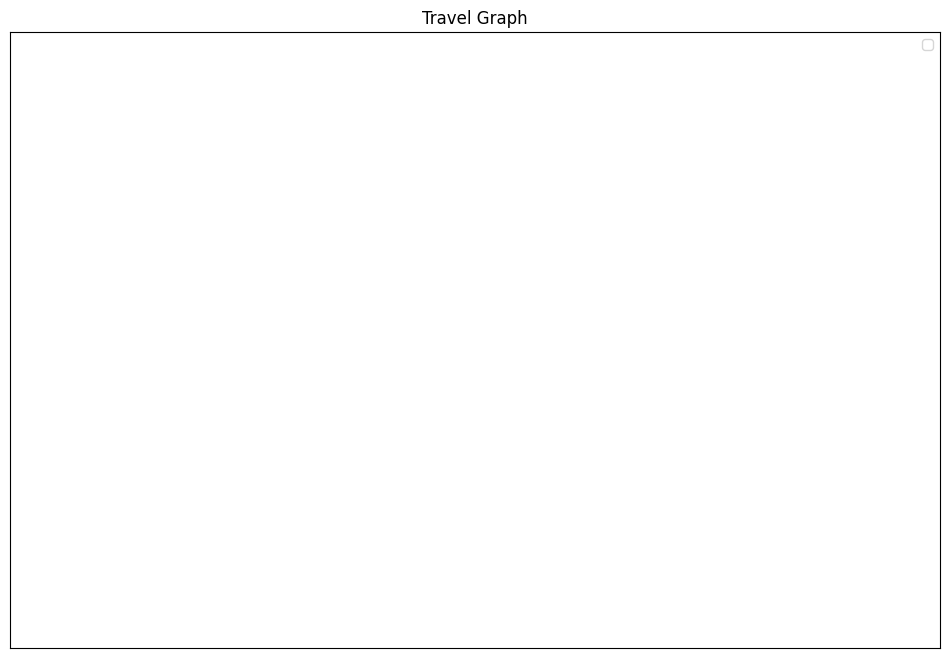

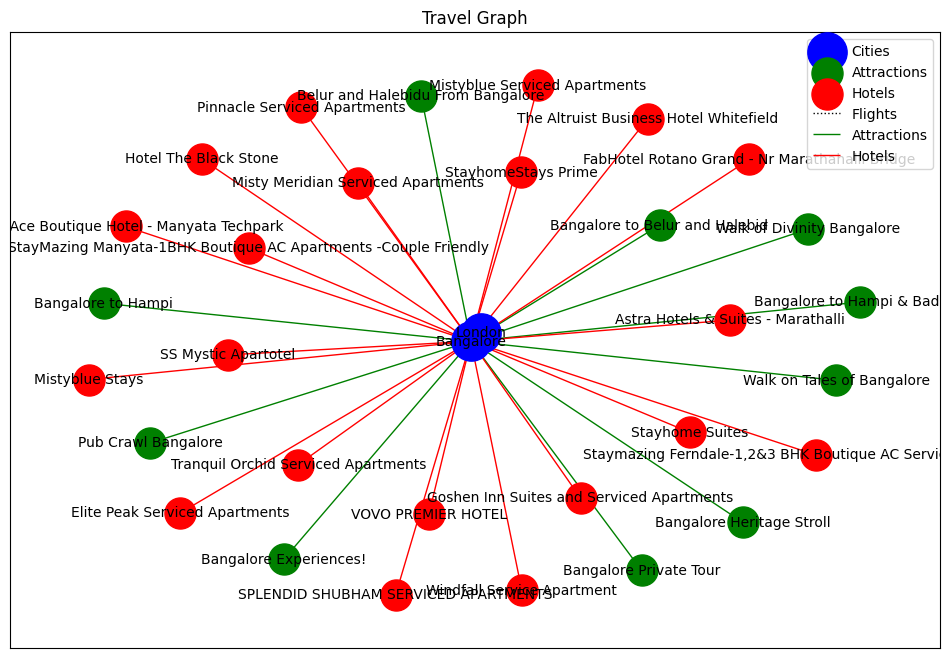

In [112]:
import networkx as nx
import matplotlib.pyplot as plt

travel_graph = nx.Graph()

def load_cities(db):
    """Load destinations (cities) into the graph."""
    try:
        destinations = [doc["name"] for doc in db.collection("destinations").all()]
        flight_destinations = [doc["city"] for doc in db.collection("flight_destinations").all()]

        all_cities = set(destinations + flight_destinations)  # Merge both collections

        for city in all_cities:
            # Ensure city is stored in ArangoDB
            if not db.collection("cities").has(city):
                db.collection("cities").insert({"_key": city, "name": city})
                print(f"✅ Added city '{city}' to database.")

            travel_graph.add_node(city, type="city")

        print(f"✅ Loaded {len(all_cities)} destinations (cities)")
    except Exception as e:
        print("❌ Error fetching cities:", str(e))


def load_attractions(db):
    """Load attractions into the graph and link them to their respective destinations."""
    try:
        attractions = db.collection("attractions").all()
        for doc in attractions:
            attraction_name = doc["name"]
            city_name = doc["destination"]  # Changed from 'city' to 'destination'
            travel_graph.add_node(attraction_name, type="attraction")
            travel_graph.add_edge(city_name, attraction_name, type="attraction")
        print(f"✅ Loaded {len(attractions)} attractions")
    except Exception as e:
        print("❌ Error fetching attractions:", str(e))

def load_hotels(db):
    """Load hotels into the graph and link them to their respective destinations."""
    try:
        hotels = db.collection("hotels").all()
        for doc in hotels:
            hotel_name = doc["name"]
            city_name = doc["destination"]  # Changed from 'city' to 'destination'
            travel_graph.add_node(hotel_name, type="hotel")
            travel_graph.add_edge(city_name, hotel_name, type="hotel")
        print(f"✅ Loaded {len(hotels)} hotels")
    except Exception as e:
        print("❌ Error fetching hotels:", str(e))

def load_flights(db):
    """Load flights as edges between cities."""
    try:
        flights = db.collection("flights").all()
        for doc in flights:
            if "from_city" not in doc or "to_city" not in doc:
                print(f"❌ Skipping invalid flight entry: {doc}")
                continue  # Skip incorrect flight entries

            from_city = doc["from_city"]
            to_city = doc["to_city"]
            flight_number = doc["flight_number"]
            price = doc.get("price", None)

            # Ensure nodes exist before adding an edge
            if from_city not in travel_graph:
                travel_graph.add_node(from_city, type="city")
            if to_city not in travel_graph:
                travel_graph.add_node(to_city, type="city")

            # Assign weight based on price
            edge_weight = float(price) if price else 1
            travel_graph.add_edge(from_city, to_city, type="flight", flight_number=flight_number, price=price, weight=edge_weight)

        print(f"✅ Loaded flights with weights")
    except Exception as e:
        print("❌ Error fetching flights:", str(e))


def display_graph():
    """Visualize the travel graph."""
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(travel_graph)

    # Classify nodes by type
    city_nodes = [node for node, attr in travel_graph.nodes(data=True) if attr["type"] == "city"]
    attraction_nodes = [node for node, attr in travel_graph.nodes(data=True) if attr["type"] == "attraction"]
    hotel_nodes = [node for node, attr in travel_graph.nodes(data=True) if attr["type"] == "hotel"]

    # Draw Nodes
    nx.draw_networkx_nodes(travel_graph, pos, nodelist=city_nodes, node_color="blue", node_size=800, label="Cities")
    nx.draw_networkx_nodes(travel_graph, pos, nodelist=attraction_nodes, node_color="green", node_size=500, label="Attractions")
    nx.draw_networkx_nodes(travel_graph, pos, nodelist=hotel_nodes, node_color="red", node_size=500, label="Hotels")

    # Draw Edges
    nx.draw_networkx_edges(travel_graph, pos, edgelist=[(u, v) for u, v, d in travel_graph.edges(data=True) if d["type"] == "flight"], edge_color="black", style="dotted", label="Flights")
    nx.draw_networkx_edges(travel_graph, pos, edgelist=[(u, v) for u, v, d in travel_graph.edges(data=True) if d["type"] == "attraction"], edge_color="green", label="Attractions")
    nx.draw_networkx_edges(travel_graph, pos, edgelist=[(u, v) for u, v, d in travel_graph.edges(data=True) if d["type"] == "hotel"], edge_color="red", label="Hotels")

    # Labels
    nx.draw_networkx_labels(travel_graph, pos, font_size=10, font_color="black")

    plt.legend()
    plt.title("Travel Graph")
    plt.show()

# Initialize the database
db = setup_arangodb()

# Pass db to the functions
load_cities(db)
load_attractions(db)
load_hotels(db)
load_flights(db)

# ✅ **Display the travel graph**
display_graph()


🔄 Connecting to ArangoDB Cloud at https://c4c335acccb7.arangodb.cloud:8529...
✅ Successfully connected to ArangoDB Cloud: Langchain
✅ Loaded 3 destinations (cities)
✅ Loaded 30 attractions
✅ Loaded 60 hotels
❌ Skipping invalid flight entry: {'_key': '72d0eab1cbba7f3ce7da2c99a4f25660', '_id': 'flights/72d0eab1cbba7f3ce7da2c99a4f25660', '_rev': '_jVbUC9O---', 'type': 'flight', 'weight': 531.4}
❌ Skipping invalid flight entry: {'_key': 'c50dd84cb20888be8bfc1c4ddb998cd7', '_id': 'flights/c50dd84cb20888be8bfc1c4ddb998cd7', '_rev': '_jVbXhTG---', 'type': 'flight', 'weight': 558.46}
❌ Skipping invalid flight entry: {'_key': 'acd78f71dcb967f28c036c675520ca1c', '_id': 'flights/acd78f71dcb967f28c036c675520ca1c', '_rev': '_jVbblPe---', 'type': 'flight', 'weight': 738.37}
✅ Loaded flights with weights


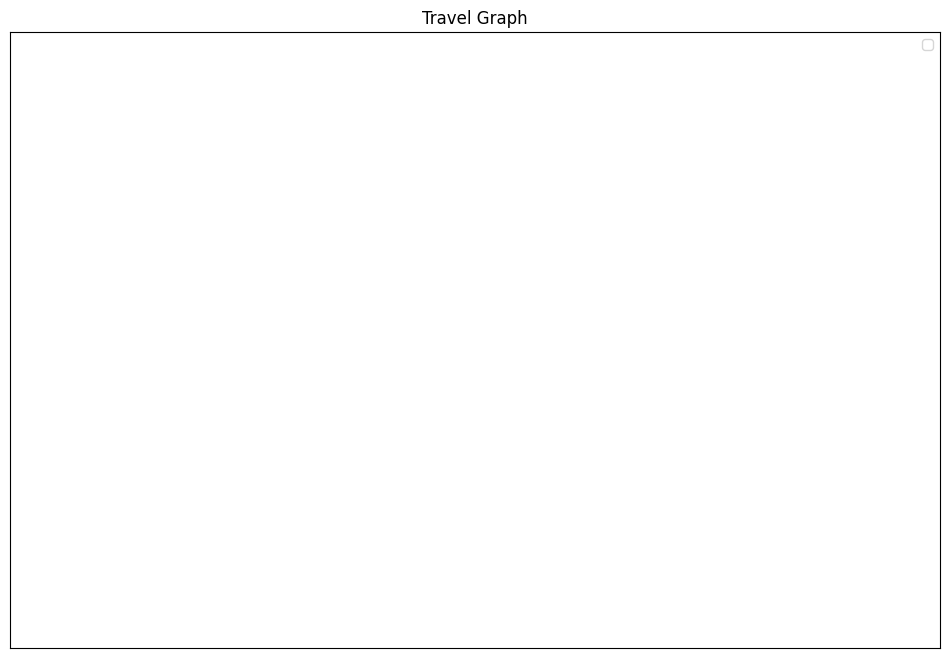

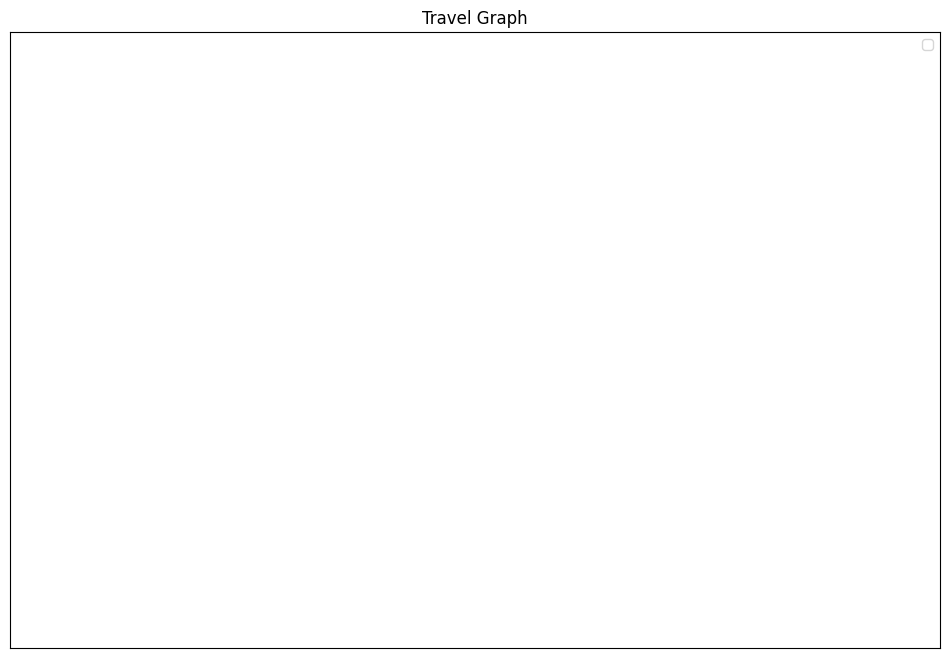

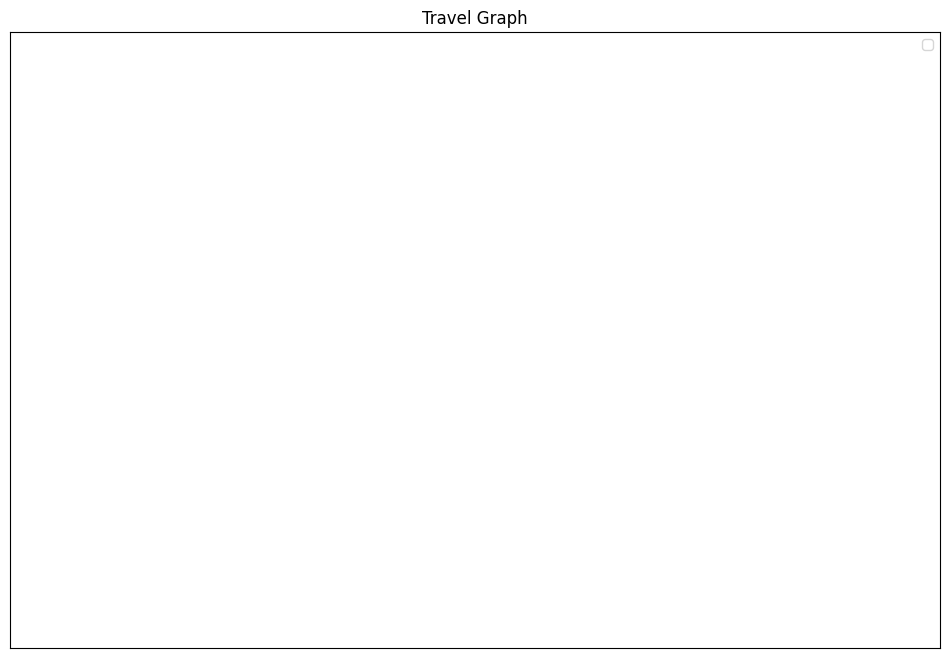

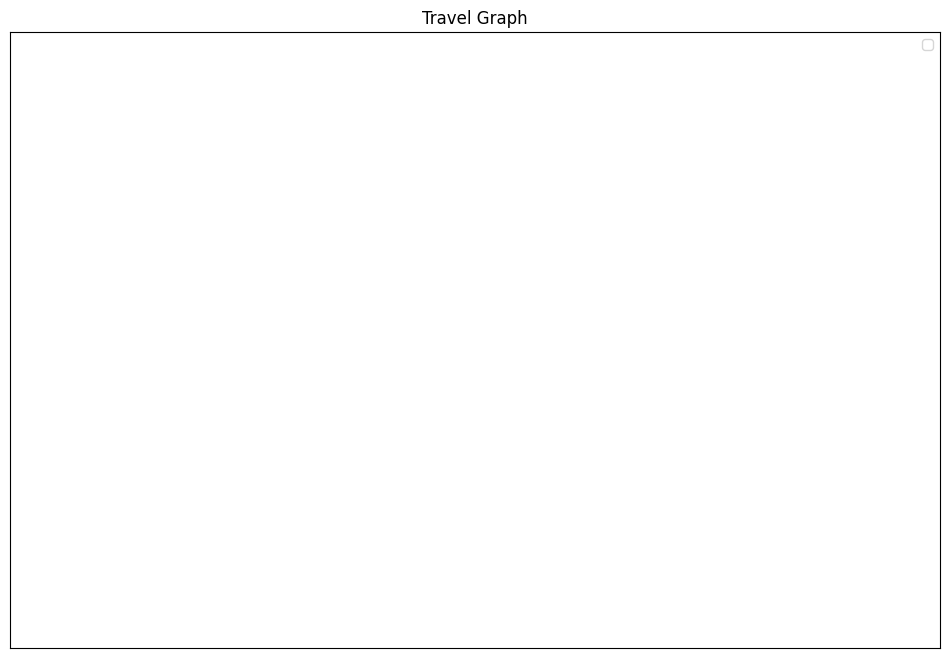

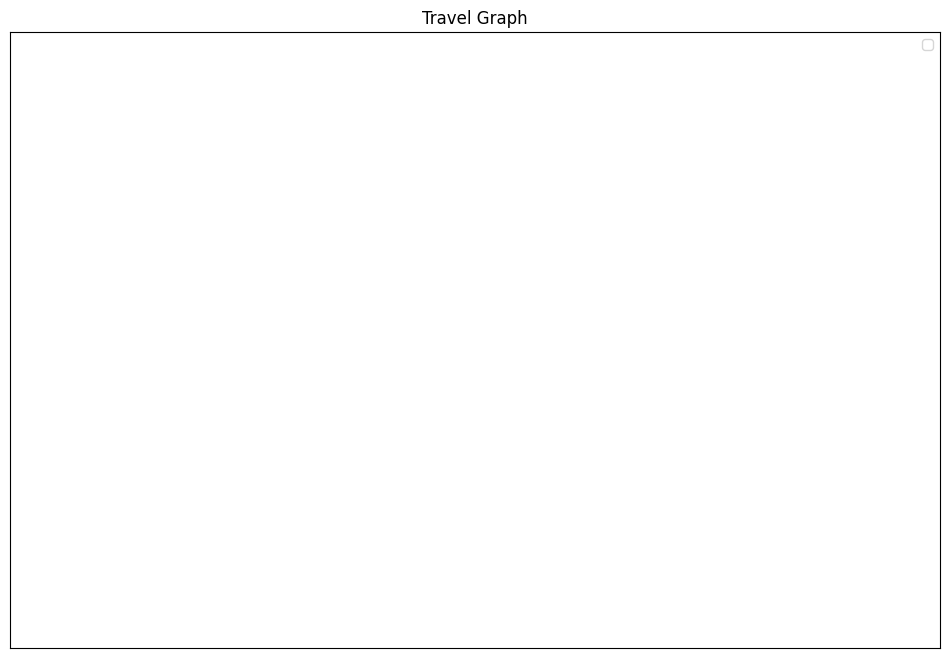

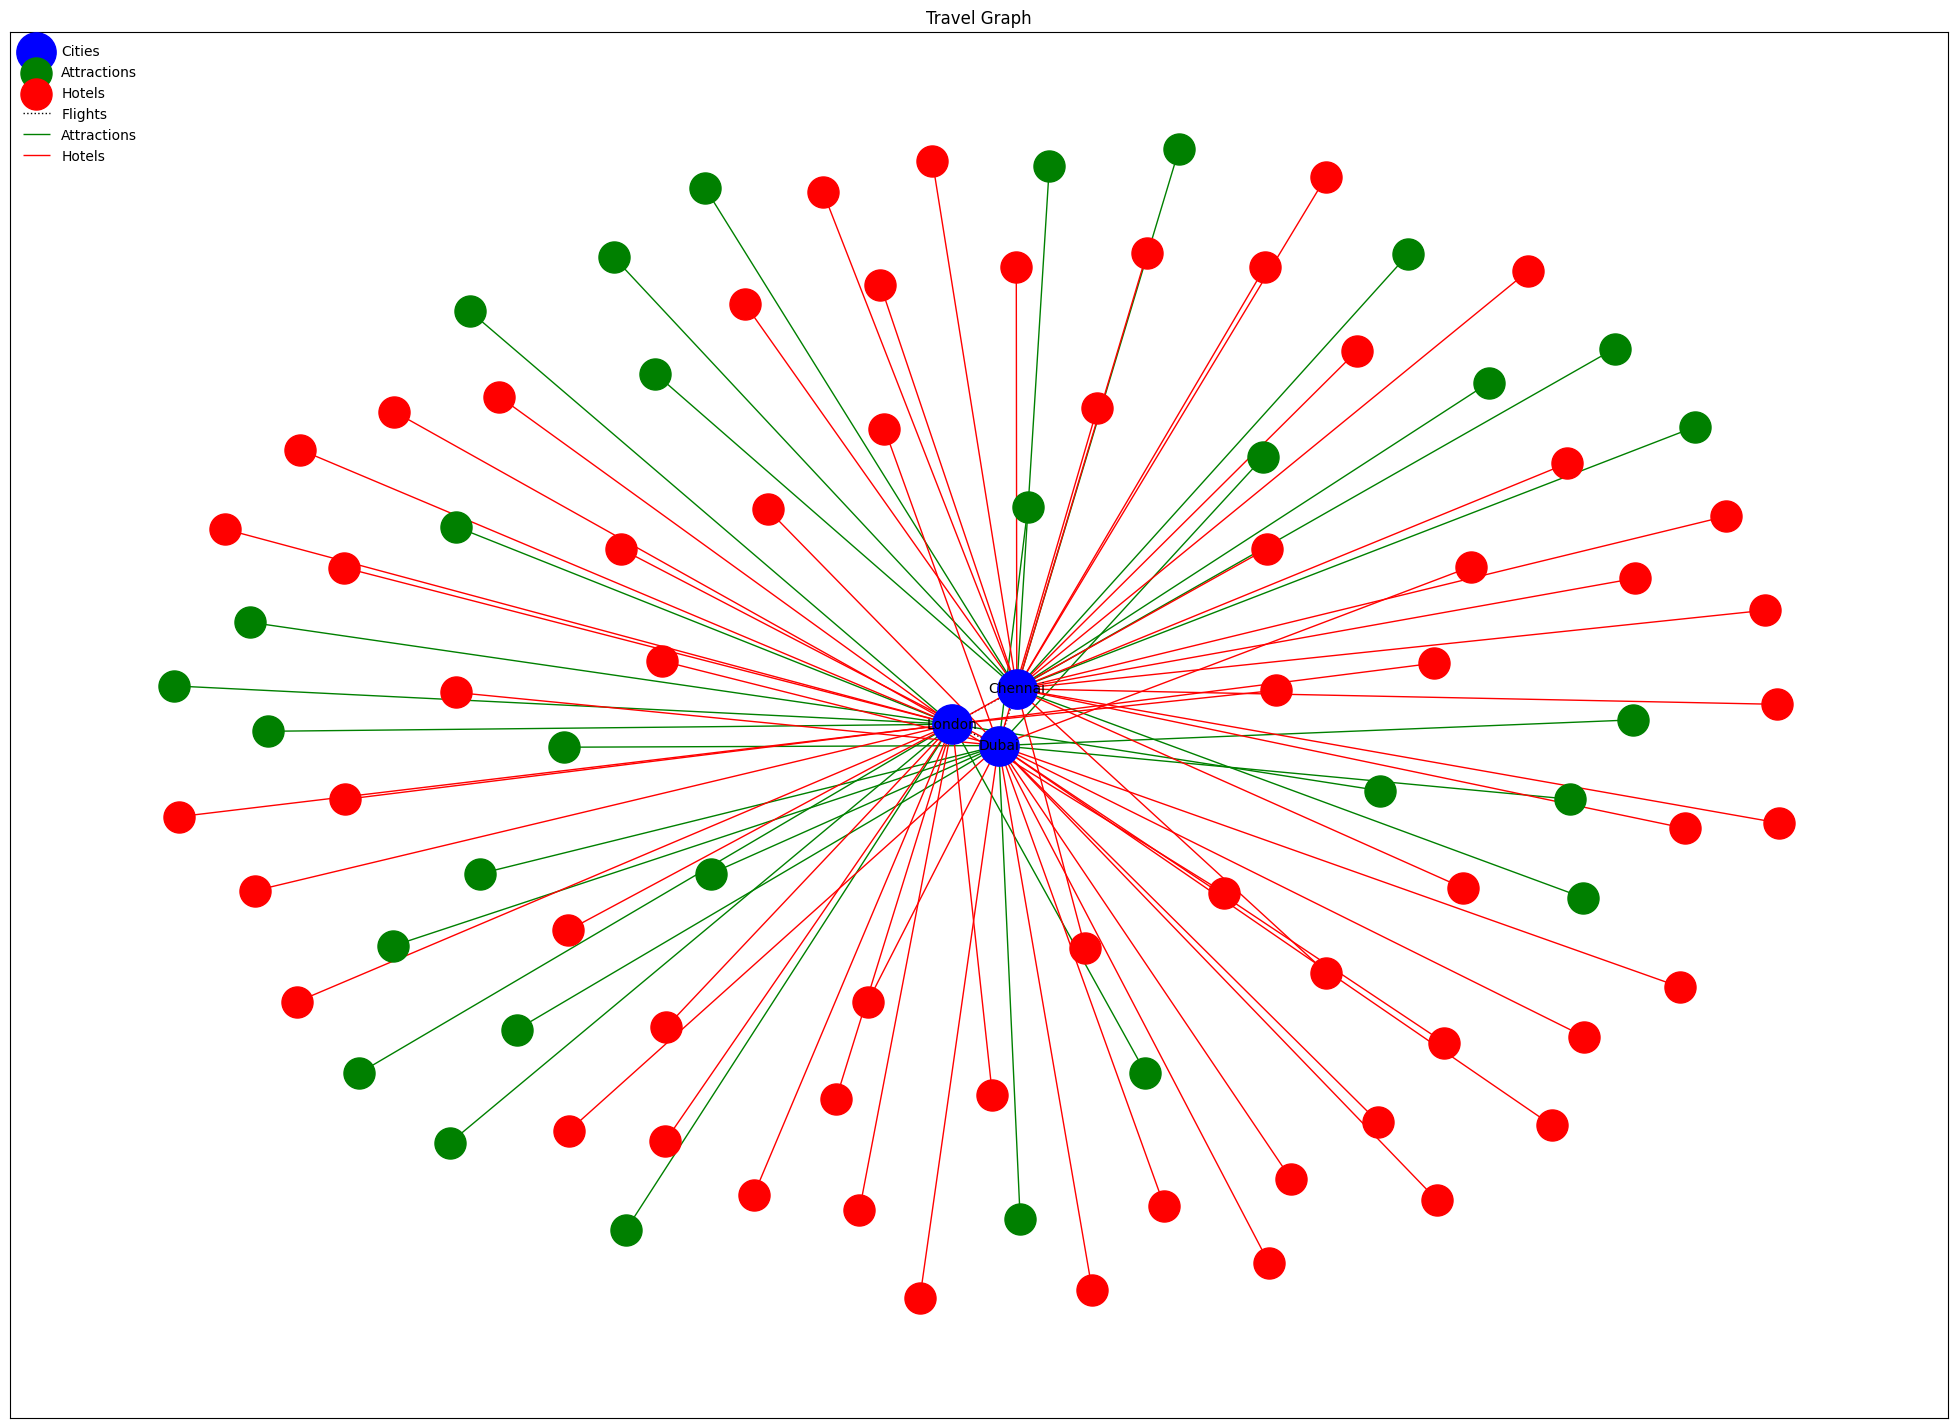

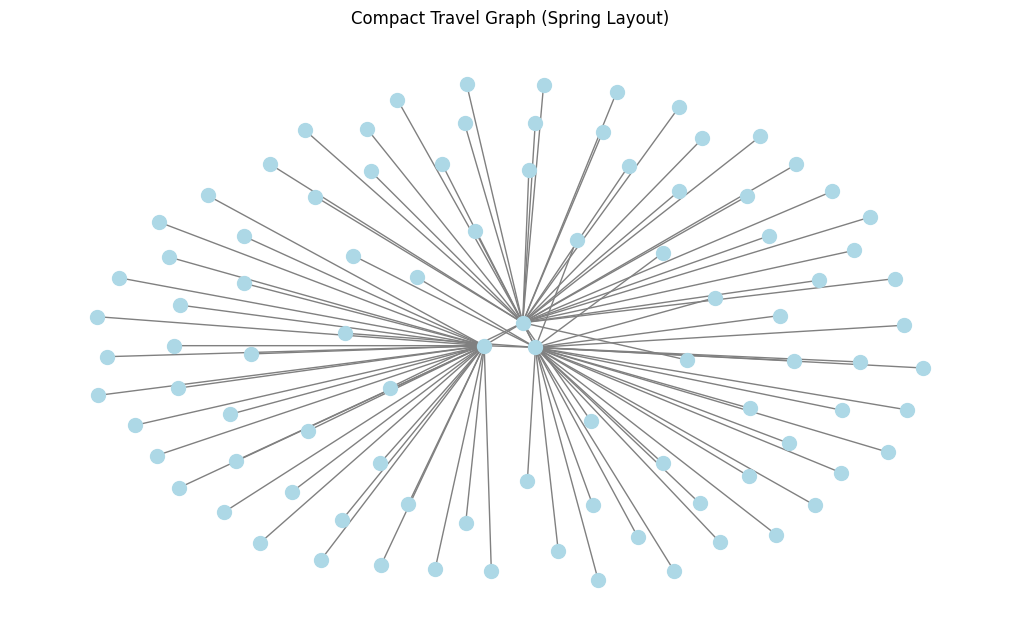

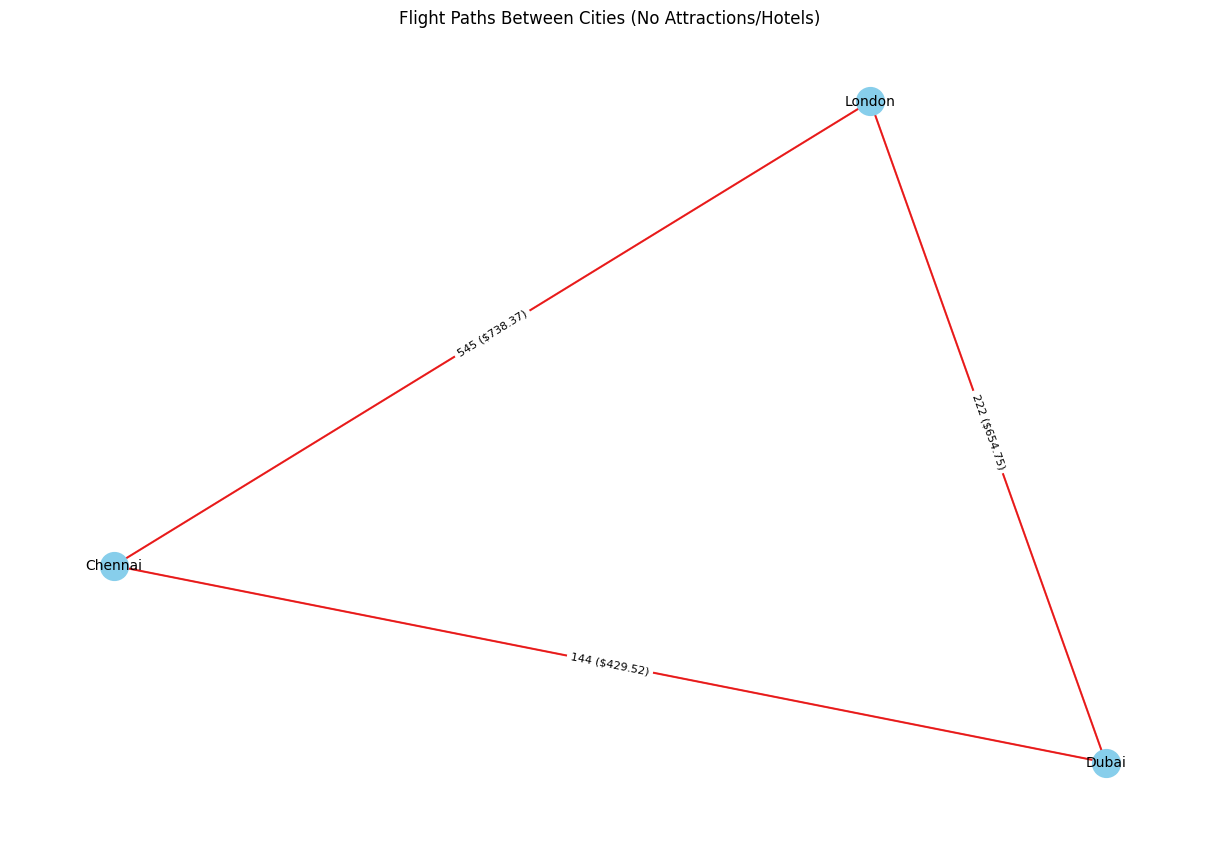

In [33]:
import networkx as nx
import matplotlib.pyplot as plt

travel_graph = nx.Graph()

def load_cities(db):
    """Load destinations (cities) into the graph."""
    try:
        destinations = [doc["name"] for doc in db.collection("destinations").all()]
        flight_destinations = [doc["city"] for doc in db.collection("flight_destinations").all()]

        all_cities = set(destinations + flight_destinations)

        for city in all_cities:
            if not db.collection("cities").has(city):
                db.collection("cities").insert({"_key": city, "name": city})
                print(f"✅ Added city '{city}' to database.")

            travel_graph.add_node(city, type="city")

        print(f"✅ Loaded {len(all_cities)} destinations (cities)")
    except Exception as e:
        print("❌ Error fetching cities:", str(e))

def load_attractions(db):
    """Load attractions into the graph and link them to their respective destinations."""
    try:
        attractions = db.collection("attractions").all()
        for doc in attractions:
            attraction_name = doc["name"]
            city_name = doc["destination"]
            travel_graph.add_node(attraction_name, type="attraction")
            travel_graph.add_edge(city_name, attraction_name, type="attraction")
        print(f"✅ Loaded {len(attractions)} attractions")
    except Exception as e:
        print("❌ Error fetching attractions:", str(e))

def load_hotels(db):
    """Load hotels into the graph and link them to their respective destinations."""
    try:
        hotels = db.collection("hotels").all()
        for doc in hotels:
            hotel_name = doc["name"]
            city_name = doc["destination"]
            travel_graph.add_node(hotel_name, type="hotel")
            travel_graph.add_edge(city_name, hotel_name, type="hotel")
        print(f"✅ Loaded {len(hotels)} hotels")
    except Exception as e:
        print("❌ Error fetching hotels:", str(e))

def load_flights(db):
    """Load flights as edges between cities."""
    try:
        flights = db.collection("flights").all()
        for doc in flights:
            if "from_city" not in doc or "to_city" not in doc:
                print(f"❌ Skipping invalid flight entry: {doc}")
                continue

            from_city = doc["from_city"]
            to_city = doc["to_city"]
            flight_number = doc["flight_number"]
            price = doc.get("price", None)

            if from_city not in travel_graph:
                travel_graph.add_node(from_city, type="city")
            if to_city not in travel_graph:
                travel_graph.add_node(to_city, type="city")

            edge_weight = float(price) if price else 1
            travel_graph.add_edge(from_city, to_city, type="flight", flight_number=flight_number, price=price, weight=edge_weight)

        print(f"✅ Loaded flights with weights")
    except Exception as e:
        print("❌ Error fetching flights:", str(e))


def display_graph():
    """Visualize the travel graph."""
    plt.figure(figsize=(25, 18))
    pos = nx.spring_layout(travel_graph)

    city_nodes = [node for node, attr in travel_graph.nodes(data=True) if attr["type"] == "city"]
    attraction_nodes = [node for node, attr in travel_graph.nodes(data=True) if attr["type"] == "attraction"]
    hotel_nodes = [node for node, attr in travel_graph.nodes(data=True) if attr["type"] == "hotel"]

    nx.draw_networkx_nodes(travel_graph, pos, nodelist=city_nodes, node_color="blue", node_size=800, label="Cities")
    nx.draw_networkx_nodes(travel_graph, pos, nodelist=attraction_nodes, node_color="green", node_size=500, label="Attractions")
    nx.draw_networkx_nodes(travel_graph, pos, nodelist=hotel_nodes, node_color="red", node_size=500, label="Hotels")

    nx.draw_networkx_edges(travel_graph, pos, edgelist=[(u, v) for u, v, d in travel_graph.edges(data=True) if d["type"] == "flight"], edge_color="black", style="dotted", label="Flights")
    nx.draw_networkx_edges(travel_graph, pos, edgelist=[(u, v) for u, v, d in travel_graph.edges(data=True) if d["type"] == "attraction"], edge_color="green", label="Attractions")
    nx.draw_networkx_edges(travel_graph, pos, edgelist=[(u, v) for u, v, d in travel_graph.edges(data=True) if d["type"] == "hotel"], edge_color="red", label="Hotels")

    #nx.draw_networkx_labels(travel_graph, pos, font_size=10, font_color="black")
    city_labels = {node: node for node in city_nodes}
    nx.draw_networkx_labels(travel_graph, pos, labels=city_labels, font_size=10, font_color="black")

    plt.legend(scatterpoints = 1, frameon = False, loc = 'upper left')
    plt.title("Travel Graph")
    plt.show()

## 🆕 New: Compact Spring Layout Graph
def display_spring_graph():
    """Compact spring layout graph."""
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(travel_graph)  # Use spring layout for compact arrangement

    nx.draw(
        travel_graph,
        pos,
        with_labels=False,
        node_size=100,
        font_size=8,
        node_color="lightblue",
        edge_color="gray"
    )

    plt.title("Compact Travel Graph (Spring Layout)")
    plt.show()


## 🆕 New: Plot Flight Paths
def plot_flight_paths():
    """Plot only flight paths between cities."""
    plt.figure(figsize=(12, 8))

    # Create a subgraph with only city nodes and flight edges
    city_graph = nx.Graph()

    for u, v, d in travel_graph.edges(data=True):
        if d["type"] == "flight":
            if travel_graph.nodes[u]["type"] == "city" and travel_graph.nodes[v]["type"] == "city":
                city_graph.add_node(u, type="city")
                city_graph.add_node(v, type="city")
                city_graph.add_edge(u, v, type="flight", flight_number=d.get("flight_number", ""), price=d.get("price", None))

    # Define spring layout positions
    pos = nx.spring_layout(city_graph)

    # Draw the graph with only city nodes
    nx.draw(
        city_graph,
        pos,
        with_labels=True,
        node_size=400,
        font_size=10,
        node_color="skyblue",
        edge_color="gray"
    )

    # Draw flight edges with arrows and labels
    flight_edges = [(u, v) for u, v, d in city_graph.edges(data=True) if d["type"] == "flight"]
    nx.draw_networkx_edges(
        city_graph,
        pos,
        edgelist=flight_edges,
        edge_color="red",
        width=1.5,
        alpha=0.8,
        arrows=True
    )

    # Optionally, label the flight number and price on the edges
    edge_labels = {(u, v): f"{d['flight_number']} (${d['price']})" for u, v, d in city_graph.edges(data=True) if "flight_number" in d and "price" in d}
    nx.draw_networkx_edge_labels(city_graph, pos, edge_labels=edge_labels, font_size=8)

    plt.title("Flight Paths Between Cities (No Attractions/Hotels)")
    plt.show()


# Initialize the database
db = setup_arangodb()

# Load Data
load_cities(db)
load_attractions(db)
load_hotels(db)
load_flights(db)

# ✅ **Display the travel graph (original)**
display_graph()

# ✅ **Display compact spring layout graph**
display_spring_graph()

# ✅ **Plot flight paths only**
plot_flight_paths()


# Step 6: AI Agent implementation using Langchain and ArangoDB

In [34]:
# 30. Initialize ArangoGraph and LangChain Integration

arango_graph1 = ArangoGraph(db)

# 🔄 Reload LangChain to avoid any version conflicts
importlib.reload(langchain_community.chat_models)

# ✅ Initialize LLM
llm = ChatOpenAI(model_name="gpt-4o", temperature=0.1, openai_api_key=openai_api_key)

# ✅ ArangoDB Connection
# (Assuming `db` is already connected)

arango_graph = ArangoGraphQAChain.from_llm(
    llm=ChatOpenAI(temperature=0, model_name="gpt-4o", openai_api_key=openai.api_key),
    graph=arango_graph1,  # Your ArangoDB connection
    verbose=True,
    allow_dangerous_requests = True
)

<ipython-input-34-4bc398e0ec28>:9: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model_name="gpt-4o", temperature=0.1, openai_api_key=openai_api_key)


In [51]:
# 31. User Preference Handling and Travel Search Tools
# ------------------------------------------------------------
# This code block defines tools for handling user travel preferences and
# searching for flights, hotels, and attractions. The tools are designed to:

user_preferences = {}

@tool
def set_user_preference(query: str):
    """Extracts and stores user travel preferences from a natural language input."""

    structured_prompt = f"""
    Extract structured travel preferences from the following user input:

    ---
    "{query}"
    ---

    Return a JSON object with **ONLY** the following fields:
    - `destination` (e.g., "Dubai")
    - `origin` (e.g., "Mumbai")
    - `travelers` (must contain `adults` and `children`)
    - `travel_dates` (must contain `start` and `end` in YYYY-MM-DD format)

    Example response:
    ```json
    {{
      "destination": "Dubai",
      "origin": "Mumbai",
      "travelers": {{
        "adults": 2,
        "children": 1
      }},
      "travel_dates": {{
        "start": "2025-03-15",
        "end": "2025-03-22"
      }}
    }}
    ```

    **DO NOT** include explanations or additional text—only return the JSON.
    """

    # ✅ Call LLM to extract structured preferences
    response = llm.invoke(structured_prompt)

    try:
        # ✅ Extract JSON using regex if the LLM returns text around the JSON
        json_match = re.search(r"\{.*\}", response.content, re.DOTALL)
        if json_match:
            extracted_json = json_match.group(0)
            extracted_data = json.loads(extracted_json)  # Convert to Python dictionary
            user_preferences.update(extracted_data)
            return f"✅ Preferences updated: {extracted_data}"
        else:
            return "❌ JSON extraction failed. Try providing details in a structured format."

    except json.JSONDecodeError as e:
        return f"❌ Error decoding JSON: {str(e)}. Please try rephrasing your input."


@tool
def get_user_preferences(query: str):
    """Retrieve stored user travel preferences."""
    return f"📝 Your preferences: {user_preferences}"

@tool
def find_flights(query: str):
    """Finds the best available flights for the user's travel."""

    # Extract structured preferences
    destination = user_preferences.get("destination", "")
    origin = user_preferences.get("origin", "")
    start_date = user_preferences.get("travel_dates", {}).get("start", "")
    end_date = user_preferences.get("travel_dates", {}).get("end", "")

    if not destination or not origin or not start_date:
        return "❌ Please provide the origin, destination, and departure date."

    # Adjust AQL query to find flights **across multiple days** (e.g., one day before & after)
    aql_query = f"""
    WITH flights
    FOR flight IN flights
      FILTER flight.from_city == "{origin}"
      FILTER flight.to_city == "{destination}"
      FILTER flight.departure_time >= "{start_date}T00:00:00"
      FILTER flight.departure_time <= "{start_date}T23:59:59"
      RETURN flight
    """

    result = arango_graph.invoke(aql_query)

    if not result["result"]:
        return f"❌ No flights found from {origin} to {destination} on {start_date}. Try adjusting your dates."

    return f"✅ Available flights: {result['result']}"


@tool
def find_hotels(query: str):
    """Finds the best hotels at a given destination."""
    return arango_graph.invoke(f"Find hotels for {query}")


@tool
def find_attractions(query: str):
    """Finds popular attractions at a given destination."""
    return arango_graph.invoke(f"Find attractions for {query}")


@tool
def summarize_trip(query: str):
    """Summarizes the trip based on stored preferences."""
    destination = user_preferences.get("destination", "Unknown")

    if destination == "Unknown":
        return "❌ Please set your travel destination first."

    flights = find_flights(destination)
    hotels = find_hotels(destination)
    attractions = find_attractions(destination)

    return f"""🎉 **Your Travel Summary for {destination}:** 🎉

✈️ **Flights:** {flights}
🏨 **Hotels:** {hotels}
🎡 **Attractions:** {attractions}
"""


In [52]:
# 32. Define AI Agent and Tools for Travel Planning
# ------------------------------------------------------------
# This code block sets up the AI agent, memory, and function-based tools
# that allow the AI to dynamically interact with user inputs and ArangoDB data.
# ------------------------------------------------------------

tools = [set_user_preference, get_user_preferences, find_flights, find_hotels, find_attractions, summarize_trip]

# ✅ Conversation Memory (Remembers User Inputs)
memory = ConversationBufferMemory(memory_key="chat_history")

# ✅ Define the AI Travel Agent
agent = initialize_agent(
    tools=tools,
    llm=llm,
    memory=memory,
    agent=AgentType.OPENAI_FUNCTIONS,  # OpenAI-powered function calls
    verbose=True
)


In [54]:
# 32. Travel Chatbot Function and Execution
# ------------------------------------------------------------
# This code block defines the travel chatbot function and starts the AI conversation.
# ------------------------------------------------------------

def travel_chatbot(user_input):
    response = agent.invoke({"input": user_input})
    return response["output"]


# ✅ Start AI Conversation
print(travel_chatbot("I would like to go from Dubai to Chennai between June 17 2025 to June 21 2025. With 2 adults and 1 child. Can you also help find flights and hotels to and fro nd provide attractions in Bangalore."))




> Entering new AgentExecutor chain...

Invoking: `set_user_preference` with `{'query': 'Travel from Dubai to Chennai between June 17, 2025, to June 21, 2025, for 2 adults and 1 child.'}`


✅ Preferences updated: {'destination': 'Chennai', 'origin': 'Dubai', 'travelers': {'adults': 2, 'children': 1}, 'travel_dates': {'start': '2025-06-17', 'end': '2025-06-21'}}
Invoking: `find_flights` with `{'query': 'Find flights from Dubai to Chennai for 2 adults and 1 child between June 17, 2025, and June 21, 2025.'}`




> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH flights
FOR flight IN flights
  FILTER flight.from_city == "Dubai"
  FILTER flight.to_city == "Chennai"
  FILTER flight.departure_time >= "2025-06-17T00:00:00"
  FILTER flight.departure_time <= "2025-06-17T23:59:59"
  RETURN flight

AQL Result:
[{'_key': 'Dubai_Chennai_511', '_id': 'flights/Dubai_Chennai_511', '_rev': '_jVbcHKK---', 'from_city': 'Dubai', 'to_city': 'Chennai', 'flight_number': 511, 'departure_airport':

# Step 7: CuGraph Implementation

## 7.1 Package Installation

In [41]:
!pip list | grep cugraph

libcugraph-cu12                    25.2.0
nx-cugraph-cu12                    25.2.0
pylibcugraph-cu12                  25.2.0


In [42]:
%%capture
!apt-get update
!apt-get install -y cuda-toolkit-11-8
!pip install cugraph-cu11 cudf-cu11 cuml-cu11 --extra-index-url=https://pypi.nvidia.com

In [43]:
import cudf
import cugraph
import cupy

print("cuDF version:", cudf.__version__)
print("cuGraph version:", cugraph.__version__)
print("CuPy version:", cupy.__version__)

cuDF version: 25.02.02
cuGraph version: 25.02.00
CuPy version: 13.3.0


In [44]:
%%capture
!pip install scipy
!pip install pyvis

## 7.2 Fetching Data from ArangoDB

In [45]:
aql_query = """
FOR flight IN flights
RETURN {
    "source": flight.from_city,
    "destination": flight.to_city
}
"""

# Execute the query and convert it to a list
result = db.aql.execute(aql_query)
edges = list(result)


## 7.3 Converting to cuDF DataFrame

In [46]:
import cudf
from collections import OrderedDict

# Convert ArangoDB result to a cuDF DataFrame
df = cudf.DataFrame(edges)

# Convert city names to numeric IDs (because cuGraph works with numeric IDs)
unique_cities = cudf.concat([df["source"], df["destination"]]).unique().to_pandas()
city_map = {city: i for i, city in enumerate(unique_cities)}

df["source"] = df["source"].map(city_map)
df["destination"] = df["destination"].map(city_map)


## 7.4 Building cuGraph

In [47]:
import cugraph

G = cugraph.Graph()
G.from_cudf_edgelist(df, source='source', destination='destination')


## 7.4 Implementing PageRank

In [48]:
df_page = cugraph.pagerank(G)

# Map back to city names
df_page['city'] = df_page['vertex'].map({v: k for k, v in city_map.items()})

# Find the most important city
best_score = df_page['pagerank'][0]
best_city = df_page['city'][0]

for i in range(len(df_page)):
    if df_page['pagerank'][i] > best_score:
        best_score = df_page['pagerank'][i]
        best_city = df_page['city'][i]

print(f"Best city is {best_city} with a score of {best_score:.4f}")


/usr/local/lib/python3.11/dist-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)


Best city is Chennai with a score of 0.2500


In [49]:
sort_pr = df_page.sort_values('pagerank', ascending=False)
print(sort_pr[['city', 'pagerank']].head().to_pandas())


      city  pagerank
0  Chennai      0.25
1    Dubai      0.25
2   London      0.25
3     None      0.25


In [45]:
import networkx as nx

# Convert ArangoDB results to a NetworkX graph
nxg = nx.from_pandas_edgelist(df.to_pandas(), source="source", target="destination")

# Run PageRank
pr_nx = nx.pagerank(nxg, alpha=0.85, max_iter=100, tol=0.00001)

# Convert to DataFrame
df_nx = pd.DataFrame(list(pr_nx.items()), columns=["city", "pagerank"])

# Map back to city names
df_nx['city'] = df_nx['city'].map({v: k for k, v in city_map.items()})

# Display top PageRank scores from NetworkX
print(df_nx.sort_values('pagerank', ascending=False).head())


        city  pagerank
1      Dubai  0.259647
3     London  0.259647
2       None  0.200000
0    Chennai  0.140353
4  Bangalore  0.140353


## 7.5 Finding Shortest Path

In [50]:
start_city = "London"
end_city = "Chennai"

# Convert city names to numeric IDs
start = city_map[start_city]
end = city_map[end_city]

bfs_results = cugraph.bfs(G, start)
path = []
current = end

# Trace the path
while current != start:
    path.append(current)
    current = bfs_results['predecessor'][current]
path.append(start)
path.reverse()

# Map back to city names
path = [unique_cities[i] for i in path]

print(f"Quickest route (min layovers) from {start_city} to {end_city}: {' → '.join(path)}")



Quickest route (min layovers) from London to Chennai: London → Chennai
